In this notebook I will try to predict StadtRad demand using available features

In [21]:
%pylab inline

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd

import seaborn as sns

import catboost
from catboost import CatBoostRegressor

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('df_all_data_hex_8.csv', header = 0, sep = ',', index_col = 'hex_id')
df = df.drop(['Unnamed: 0','geometry'], axis = 1)

In [3]:
df["bin"] = pd.qcut(df["bike_start"],10, retbins=False, labels=["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"])
df["bin"] = df["bin"].apply(lambda x: int(x)).cat.codes

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(['bike_start',
                                                             'bike_end','counts','bin', 'rank'], axis = 1),
                                                    df['bin'], test_size = 0.30)


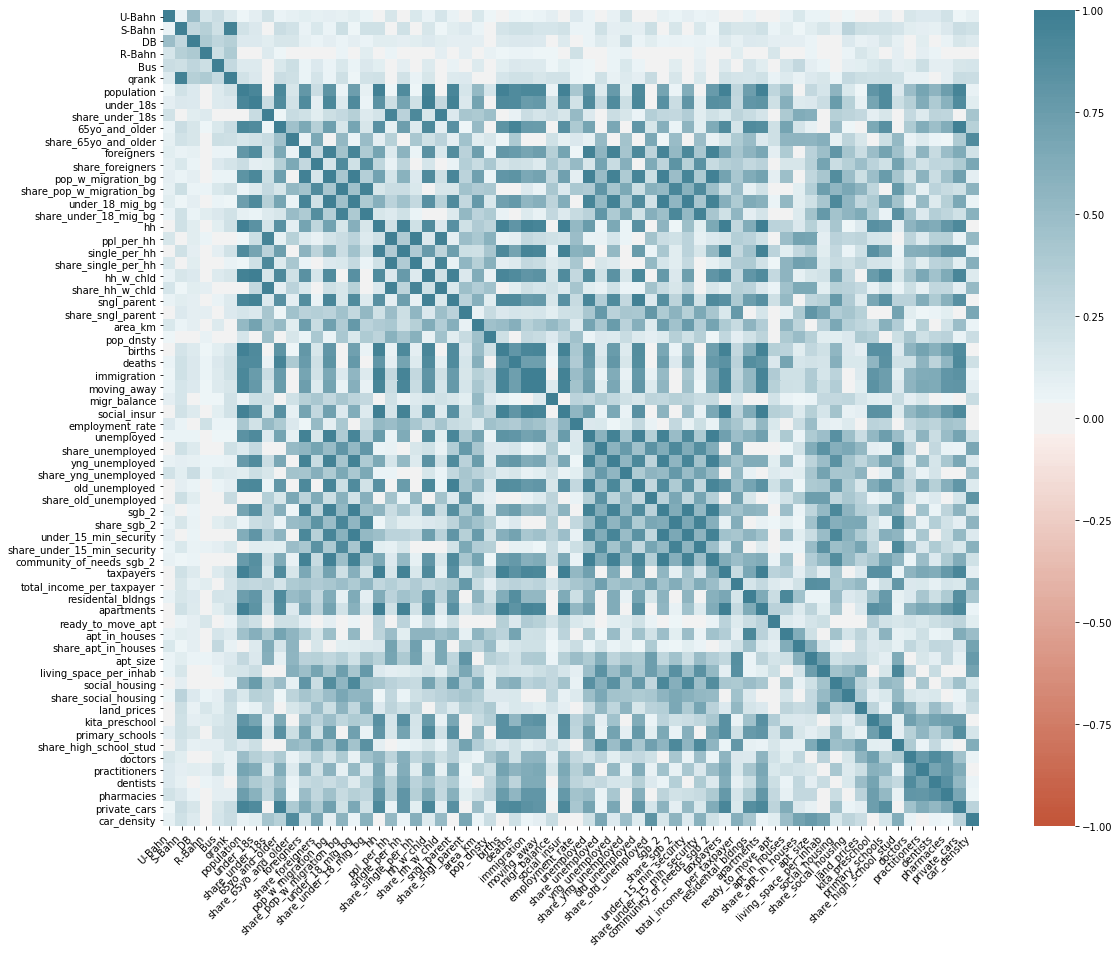

In [7]:
corr = abs(X_train.corr())

plt.figure(figsize=(20, 15))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [8]:
sol = (corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

dict(sol[sol > 0.9])

{('hh', 'apartments'): 0.9980300889974362,
 ('taxpayers', 'apartments'): 0.9961354192064864,
 ('hh', 'social_insur'): 0.9953314493641128,
 ('social_insur', 'apartments'): 0.9947022536170845,
 ('hh', 'taxpayers'): 0.9942562685656762,
 ('social_insur', 'taxpayers'): 0.9926021055331868,
 ('sgb_2', 'under_15_min_security'): 0.9905577417395109,
 ('under_18s', 'hh_w_chld'): 0.9896368433141377,
 ('sgb_2', 'community_of_needs_sgb_2'): 0.9872055125878928,
 ('immigration', 'moving_away'): 0.986281855535798,
 ('ppl_per_hh', 'share_single_per_hh'): 0.9852674313307591,
 ('pop_w_migration_bg', 'under_18_mig_bg'): 0.9845086131180353,
 ('unemployed', 'community_of_needs_sgb_2'): 0.9828930818592625,
 ('under_18_mig_bg', 'sgb_2'): 0.9803040262047515,
 ('65yo_and_older', 'private_cars'): 0.9794481621180529,
 ('under_18_mig_bg', 'under_15_min_security'): 0.9766047689506279,
 ('population', 'taxpayers'): 0.9762197318199967,
 ('ppl_per_hh', 'share_hh_w_chld'): 0.9750191404489948,
 ('population', 'births'): 

Let's try linear model with feature selection

In [ ]:
regressor = Lasso(random_state = 0)
scaler = StandardScaler()
scaler.fit(X_train, Y_train)

pipeline = Pipeline(steps = [('scaling', scaler), ('regression', regressor)])

In [ ]:
parameters_grid = {
    'regression__alpha' : [0.0001, 0.01],
    'scaling__with_mean' : [0., 0.5],
}

In [9]:
grid_cv = model_selection.GridSearchCV(pipeline, parameters_grid, scoring = 'neg_mean_squared_error', cv = 4)

grid_cv.fit(X_train, Y_train)

/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37.77650579388636, tolerance: 0.05389852941176471
  positive)
/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.966137515394042, tolerance: 0.05762352941176471
  positive)
/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27.932465137941595, tolerance: 0.057051470588235294
  positive)
/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWa

GridSearchCV(cv=4, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaling',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('regression',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False, random_state=0,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'regression__alpha': [0.0001, 0.0

In [10]:
metrics.mean_absolute_error(Y_test, grid_cv.best_estimator_.predict(X_test))

1.5001208414777334

In [11]:
Y_test.mean()

4.85

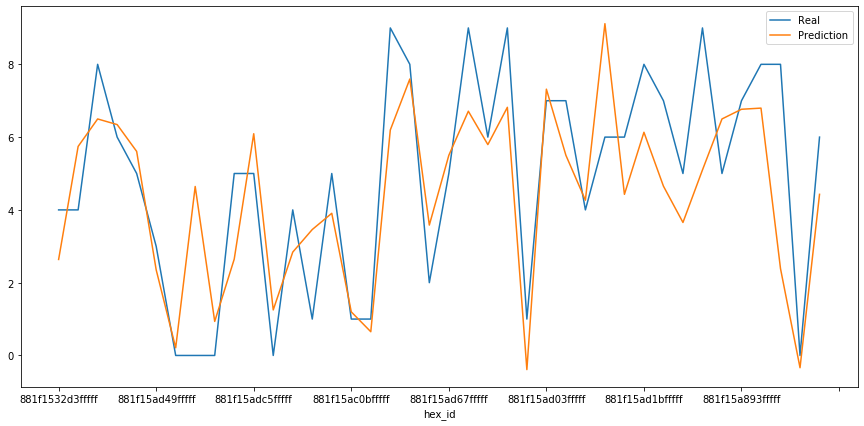

In [12]:
plt.figure(figsize(15,7))
Y_test.plot(label='Real')
plt.plot(grid_cv.best_estimator_.predict(X_test), label='Prediction')
plt.legend()

In [13]:
feature_importances = pd.DataFrame({'Features': list(X_train.columns),
                                    'Importance': abs(grid_cv.best_estimator_.named_steps['regression'].coef_)})
feature_importances = feature_importances.sort_values(by='Importance',ascending=False)

feature_importances.head(10)

,Features,Importance
7,under_18s,2.852475
43,share_under_15_min_security,2.059519
18,ppl_per_hh,1.869250
54,social_housing,1.547134
41,share_sgb_2,1.219237
14,share_pop_w_migration_bg,1.010769
24,share_sngl_parent,0.939796
5,qrank,0.767451
1,S-Bahn,0.715535
26,pop_dnsty,0.616448


Now let's try a catboost

In [15]:
model = CatBoostRegressor(random_seed = 3)

In [16]:
parameters_grid = {
    'iterations' : np.linspace(1, 50, num = 10),
    'loss_function' : ['MAE', 'RMSE'],
    'depth' : np.linspace(1, 10)
}

In [17]:
grid_cv = model_selection.GridSearchCV(model, parameters_grid, scoring = 'neg_mean_squared_error', cv = 4)

grid_cv.fit(X_train, Y_train)

0:	learn: 2.3920577	total: 50ms	remaining: 0us
0:	learn: 2.4874989	total: 417us	remaining: 0us
0:	learn: 2.5026460	total: 444us	remaining: 0us
0:	learn: 2.3678250	total: 464us	remaining: 0us
Learning rate set to 0.5
0:	learn: 2.4530202	total: 283us	remaining: 0us
Learning rate set to 0.5
0:	learn: 2.4233799	total: 271us	remaining: 0us
Learning rate set to 0.5
0:	learn: 2.3488016	total: 286us	remaining: 0us
Learning rate set to 0.5
0:	learn: 2.4296567	total: 366us	remaining: 0us


/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/json_helper.h:153: Can't parse parameter "iterations" with value: 6.444444444

  FitFailedWarning)
/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/json_helper.h:153: Can't parse parameter "iterations" with value: 11.88888889

  FitFailedWarning)
/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will 

0:	learn: 2.3920577	total: 512us	remaining: 25.1ms
1:	learn: 2.3638136	total: 1.02ms	remaining: 24.6ms
2:	learn: 2.3380772	total: 1.44ms	remaining: 22.5ms
3:	learn: 2.3035612	total: 1.84ms	remaining: 21.2ms
4:	learn: 2.2710969	total: 2.35ms	remaining: 21.2ms
5:	learn: 2.2429156	total: 2.85ms	remaining: 20.9ms
6:	learn: 2.2223889	total: 3.3ms	remaining: 20.3ms
7:	learn: 2.1838448	total: 3.83ms	remaining: 20.1ms
8:	learn: 2.1645771	total: 4.27ms	remaining: 19.5ms
9:	learn: 2.1395758	total: 4.76ms	remaining: 19.1ms
10:	learn: 2.1263982	total: 5.41ms	remaining: 19.2ms
11:	learn: 2.1122827	total: 6.3ms	remaining: 20ms
12:	learn: 2.0942114	total: 6.79ms	remaining: 19.3ms
13:	learn: 2.0696783	total: 8.05ms	remaining: 20.7ms
14:	learn: 2.0507595	total: 8.56ms	remaining: 20ms
15:	learn: 2.0253778	total: 9.48ms	remaining: 20.2ms
16:	learn: 1.9946893	total: 10ms	remaining: 19.4ms
17:	learn: 1.9896520	total: 10.8ms	remaining: 19.2ms
18:	learn: 1.9722190	total: 11.2ms	remaining: 18.3ms
19:	learn: 1

21:	learn: 1.6168323	total: 12.8ms	remaining: 16.3ms
22:	learn: 1.6003978	total: 14.4ms	remaining: 16.9ms
23:	learn: 1.5787452	total: 15.2ms	remaining: 16.4ms
24:	learn: 1.5587029	total: 16.7ms	remaining: 16.7ms
25:	learn: 1.5463432	total: 18.2ms	remaining: 16.8ms
26:	learn: 1.5363275	total: 18.7ms	remaining: 15.9ms
27:	learn: 1.5161226	total: 19.2ms	remaining: 15.1ms
28:	learn: 1.5046182	total: 20.3ms	remaining: 14.7ms
29:	learn: 1.4903260	total: 20.6ms	remaining: 13.8ms
30:	learn: 1.4818175	total: 21.4ms	remaining: 13.1ms
31:	learn: 1.4640939	total: 22.2ms	remaining: 12.5ms
32:	learn: 1.4567105	total: 28.2ms	remaining: 14.5ms
33:	learn: 1.4432181	total: 29.1ms	remaining: 13.7ms
34:	learn: 1.4293912	total: 29.9ms	remaining: 12.8ms
35:	learn: 1.4189689	total: 35.1ms	remaining: 13.6ms
36:	learn: 1.4109101	total: 35.9ms	remaining: 12.6ms
37:	learn: 1.4030118	total: 36.8ms	remaining: 11.6ms
38:	learn: 1.3938144	total: 39ms	remaining: 11ms
39:	learn: 1.3822186	total: 40.3ms	remaining: 10.1

/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/json_helper.h:153: Can't parse parameter "depth" with value: 1.183673469

  FitFailedWarning)
/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/json_helper.h:153: Can't parse parameter "iterations" with value: 6.444444444

  FitFailedWarning)
/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be se

/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/json_helper.h:153: Can't parse parameter "depth" with value: 3.755102041

  FitFailedWarning)
/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/json_helper.h:153: Can't parse parameter "depth" with value: 3.93877551

  FitFailedWarning)
/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to n

/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/json_helper.h:153: Can't parse parameter "depth" with value: 7.795918367

  FitFailedWarning)
/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/json_helper.h:153: Can't parse parameter "depth" with value: 7.979591837

  FitFailedWarning)
/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 

0:	learn: 2.3814695	total: 16.3ms	remaining: 0us
0:	learn: 2.4702930	total: 11.3ms	remaining: 0us
0:	learn: 2.4841166	total: 6.79ms	remaining: 0us
0:	learn: 2.3330425	total: 12.6ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 2.3194455	total: 3.41ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 2.3601544	total: 10.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 2.4338171	total: 11.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 2.3754364	total: 11.6ms	remaining: 0us


/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/json_helper.h:153: Can't parse parameter "iterations" with value: 6.444444444

  FitFailedWarning)
/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: catboost/private/libs/options/json_helper.h:153: Can't parse parameter "iterations" with value: 11.88888889

  FitFailedWarning)
/Users/obielov/anaconda3/envs/visual/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will 

0:	learn: 2.3814695	total: 18.2ms	remaining: 890ms
1:	learn: 2.3262695	total: 30.6ms	remaining: 735ms
2:	learn: 2.2724067	total: 41.5ms	remaining: 651ms
3:	learn: 2.2349777	total: 48ms	remaining: 553ms
4:	learn: 2.1835417	total: 58.7ms	remaining: 529ms
5:	learn: 2.1457206	total: 61ms	remaining: 448ms
6:	learn: 2.1017933	total: 65ms	remaining: 399ms
7:	learn: 2.0487083	total: 70.6ms	remaining: 370ms
8:	learn: 2.0043957	total: 81.6ms	remaining: 372ms
9:	learn: 1.9644097	total: 92ms	remaining: 368ms
10:	learn: 1.9192918	total: 103ms	remaining: 367ms
11:	learn: 1.8824048	total: 106ms	remaining: 335ms
12:	learn: 1.8531025	total: 108ms	remaining: 307ms
13:	learn: 1.8082052	total: 119ms	remaining: 305ms
14:	learn: 1.7689559	total: 129ms	remaining: 301ms
15:	learn: 1.7263203	total: 140ms	remaining: 297ms
16:	learn: 1.6941936	total: 146ms	remaining: 283ms
17:	learn: 1.6536777	total: 156ms	remaining: 277ms
18:	learn: 1.6256050	total: 158ms	remaining: 257ms
19:	learn: 1.5907764	total: 168ms	remai

20:	learn: 1.4943926	total: 236ms	remaining: 326ms
21:	learn: 1.4600657	total: 251ms	remaining: 320ms
22:	learn: 1.4271758	total: 264ms	remaining: 310ms
23:	learn: 1.3943420	total: 275ms	remaining: 298ms
24:	learn: 1.3678661	total: 287ms	remaining: 287ms
25:	learn: 1.3419350	total: 291ms	remaining: 269ms
26:	learn: 1.3128033	total: 303ms	remaining: 258ms
27:	learn: 1.2861016	total: 315ms	remaining: 247ms
28:	learn: 1.2612925	total: 327ms	remaining: 237ms
29:	learn: 1.2353782	total: 338ms	remaining: 225ms
30:	learn: 1.2158371	total: 341ms	remaining: 209ms
31:	learn: 1.1925130	total: 353ms	remaining: 198ms
32:	learn: 1.1692785	total: 364ms	remaining: 187ms
33:	learn: 1.1454987	total: 375ms	remaining: 177ms
34:	learn: 1.1212937	total: 387ms	remaining: 166ms
35:	learn: 1.0981381	total: 399ms	remaining: 155ms
36:	learn: 1.0818017	total: 410ms	remaining: 144ms
37:	learn: 1.0655015	total: 422ms	remaining: 133ms
38:	learn: 1.0430171	total: 433ms	remaining: 122ms
39:	learn: 1.0236715	total: 452

38:	learn: 0.4439121	total: 439ms	remaining: 124ms
39:	learn: 0.4196235	total: 449ms	remaining: 112ms
40:	learn: 0.4044818	total: 460ms	remaining: 101ms
41:	learn: 0.3825594	total: 474ms	remaining: 90.3ms
42:	learn: 0.3605898	total: 487ms	remaining: 79.2ms
43:	learn: 0.3415283	total: 498ms	remaining: 68ms
44:	learn: 0.3258301	total: 510ms	remaining: 56.6ms
45:	learn: 0.3125986	total: 521ms	remaining: 45.3ms
46:	learn: 0.2999020	total: 533ms	remaining: 34ms
47:	learn: 0.2877916	total: 539ms	remaining: 22.5ms
48:	learn: 0.2816901	total: 550ms	remaining: 11.2ms
49:	learn: 0.2677321	total: 562ms	remaining: 0us
Learning rate set to 0.236319
0:	learn: 2.5997666	total: 11.5ms	remaining: 561ms
1:	learn: 2.3874766	total: 18.1ms	remaining: 435ms
2:	learn: 2.2007431	total: 24ms	remaining: 376ms
3:	learn: 2.0480980	total: 27.6ms	remaining: 317ms
4:	learn: 1.9087186	total: 38.4ms	remaining: 345ms
5:	learn: 1.7990523	total: 44.7ms	remaining: 328ms
6:	learn: 1.7029499	total: 61.7ms	remaining: 379ms
7

GridSearchCV(cv=4, error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x1a2510d410>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': array([ 1.        ,  1.18367347,  1.36734694,  1.55102041,  1.73469388,
        1.91836735,  2.10204082,  2.28571429,  2.46938776,  2.65306122,
        2.83673469,  3.02040816,  3.20408163,  3.3877551 ,  3.57142857,
        3.75510204,  3.93877551,  4.12244898,  4.30612...
        8.34693878,  8.53061224,  8.71428571,  8.89795918,  9.08163265,
        9.26530612,  9.44897959,  9.63265306,  9.81632653, 10.        ]),
                         'iterations': array([ 1.        ,  6.44444444, 11.88888889, 17.33333333, 22.77777778,
       28.22222222, 33.66666667, 39.11111111, 44.55555556, 50.        ]),
                         'loss_function': ['MAE', 'RMSE']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [18]:
metrics.mean_absolute_error(Y_test, grid_cv.best_estimator_.predict(X_test))

1.579812516443401

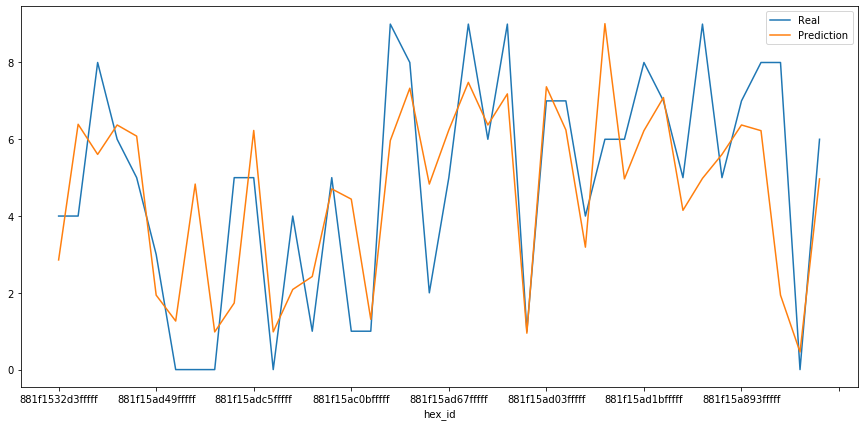

In [19]:
plt.figure(figsize(15,7))
ax = Y_test.plot(label='Real')
bx = plt.plot(grid_cv.best_estimator_.predict(X_test), label='Prediction')
plt.legend()

In [20]:
feature_importances = pd.DataFrame({'Features': list(X_train.columns),
                                    'Importance': abs(grid_cv.best_estimator_.get_feature_importance())})
feature_importances = feature_importances.sort_values(by='Importance',ascending=False)

feature_importances.head(10)

,Features,Importance
18,ppl_per_hh,23.815946
50,apt_in_houses,17.162794
8,share_under_18s,10.599442
25,area_km,10.396199
26,pop_dnsty,6.551958
20,share_single_per_hh,5.949817
51,share_apt_in_houses,5.816217
40,sgb_2,3.845185
42,under_15_min_security,3.844790
4,Bus,1.763467


Potential improvement of above - remove corellated duplicated features 